In [34]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [35]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['TCS.NS','RELIANCE.NS','SBIN.NS','ITC.NS','INFY.NS']

In [36]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 TCS.NS  RELIANCE.NS     SBIN.NS      ITC.NS      INFY.NS
Date                                                                     
2008-09-29   115.319542   429.731323  118.080917   45.200371   125.594612
2008-09-30   123.801071   433.399811  122.945480   44.420856   126.022812
2008-10-01   124.945015   423.917511  126.398537   45.448391   130.642578
2008-10-03   122.294533   391.623901  124.651039   44.987774   125.468414
2008-10-06   115.133522   364.977661  120.433403   42.519287   118.865532
...                 ...          ...         ...         ...          ...
2023-09-18  3606.149902  2436.449951  603.950012  452.049988  1

In [37]:
### Calculate the daily log returns and drop any NAs
### Because its easier to add log returns 
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
###  Delete any not applicable values
log_returns  = log_returns.dropna()

print(log_returns)

              TCS.NS  RELIANCE.NS   SBIN.NS    ITC.NS   INFY.NS
Date                                                           
2008-09-30  0.070969     0.008500  0.040371 -0.017396  0.003404
2008-10-01  0.009198    -0.022122  0.027699  0.022868  0.036002
2008-10-03 -0.021441    -0.079237 -0.013922 -0.010187 -0.040411
2008-10-06 -0.060340    -0.070466 -0.034421 -0.056433 -0.054061
2008-10-07 -0.072171     0.019933 -0.019087 -0.031032 -0.012860
...              ...          ...       ...       ...       ...
2023-09-18  0.002179    -0.008745  0.008564  0.008219 -0.013185
2023-09-20 -0.000028    -0.022539 -0.004730  0.001989 -0.001040
2023-09-21 -0.005771    -0.007310 -0.021779 -0.012105  0.007687
2023-09-22  0.005105    -0.004174  0.016860 -0.009881 -0.003736
2023-09-25 -0.007381    -0.006176 -0.006878 -0.001129 -0.014814

[3693 rows x 5 columns]


In [38]:
### Create a function that will be used to calculate portfolio expected return
###We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
### Corelation matrix finds correlation of each stock with each other

def standard_deviation (weights, cov_matrix):
    ### transpose of weight * matrix * original weight matrix
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [39]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

               TCS.NS  RELIANCE.NS   SBIN.NS    ITC.NS   INFY.NS
TCS.NS       0.000323     0.000123  0.000097  0.000075  0.000193
RELIANCE.NS  0.000123     0.000401  0.000196  0.000093  0.000116
SBIN.NS      0.000097     0.000196  0.000504  0.000120  0.000091
ITC.NS       0.000075     0.000093  0.000120  0.000276  0.000061
INFY.NS      0.000193     0.000116  0.000091  0.000061  0.000338


In [40]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
## equally weighted
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [41]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)
### portfolio_value * portfolio_expected_return * days= expected return over than number of days
### this factors in volatility

In [42]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [43]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
### if days increase var increases , if confidence interval increases var increases
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

123458.26885250007


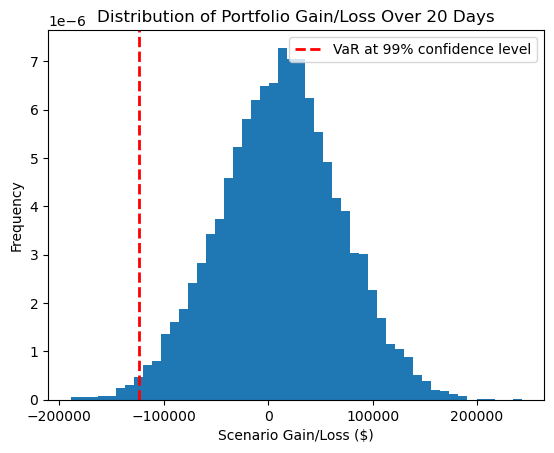

In [44]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()